In [ ]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

# MNIST 데이터셋 로드 (학습용과 검증용)
transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_val = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def get_data_samples(mnist_dataset, max_samples=1000):
    coords = []
    labels = []
    pixel_values = []
    
    for idx, (image, label) in enumerate(tqdm(mnist_dataset, desc="Processing images")):
        label = torch.tensor(label)
        # 이미지 좌표 정규화 (-1 to 1)
        for x in range(28):
            for y in range(28):
                # 좌표 정규화 (-1 to 1 범위로)
                norm_x = (x / 27.0) * 2 - 1
                norm_y = (y / 27.0) * 2 - 1
                coords.append((norm_x, norm_y))
                labels.append(label)
                pixel_values.append(image[0, x, y])  # 픽셀 값
        
        if idx + 1 >= max_samples:
            break
    
    # 텐서로 변환
    coords = torch.tensor(coords, dtype=torch.float32)  # (N, 2)
    labels = torch.tensor(labels)  # (N,)
    pixel_values = torch.tensor(pixel_values, dtype=torch.float32)  # (N,)
    
    return TensorDataset(coords, labels, pixel_values)

# 학습/검증 데이터셋 생성
train_samples = 1000  # 학습용 이미지 개수
val_samples = 200     # 검증용 이미지 개수

train_dataset = get_data_samples(mnist_train, max_samples=train_samples)
val_dataset = get_data_samples(mnist_val, max_samples=val_samples)

# DataLoader 생성
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 데이터셋 크기 확인
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

In [3]:
from model import INRformer
import torch 
import torch.nn as nn

model = INRformer()

print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

INRformer(
  (coord_embedding): Linear(in_features=2, out_features=128, bias=True)
  (label_embedding): Embedding(10, 128)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (mlp1): MLP(
    (fc1): Linear(in_features=128, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=128, bias=True)
    (gelu): GELU(approximate='none')
  )
  (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (cross_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (mlp2): MLP(
    (fc1): Linear(in_features=128, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=128, bias=True)
    (gelu): GELU(approximate='none')
  )
  (norm4): LayerNorm((128,), eps=1e-0

In [ ]:
from train import *

# 하이퍼파라미터 설정
config = {
    'lr': 1e-4,
    'weight_decay': 1e-5,
    'epochs': 10,
    'batch_size': 32,
    'd_model': 128,
    'num_classes': 10,
}

# Wandb 초기화 (옵션)
wandb.init(project="inrformer", config=config)

# Device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 초기화
model = INRformer(num_classes=config['num_classes'], d_model=config['d_model']).to(device)

# Optimizer 설정
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay']
)

# Learning rate scheduler 설정
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config['lr'],
    epochs=config['epochs'],
    steps_per_epoch=len(train_loader),
    pct_start=0.1,  # 10% warmup
)

# Loss function 설정
loss_fn = nn.MSELoss()

# Mixed precision 설정
scaler = GradScaler()

# 체크포인트 저장을 위한 변수
best_val_loss = float('inf')

# 학습 루프
for epoch in range(config['epochs']):
    # 학습
    train_loss = train_one_epoch(
        model, train_loader, optimizer, scheduler,
        loss_fn, scaler, device, epoch
    )
    
    # 검증
    val_loss = validate(model, val_loader, loss_fn, device)
    
    # Wandb 로깅
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
    })
    
    # 모델 체크포인트 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_model.pth')
    
    print(f"Epoch {epoch + 1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print("-" * 50)



Loaded model from epoch 1
Train loss: 0.0556
Val loss: 0.0563


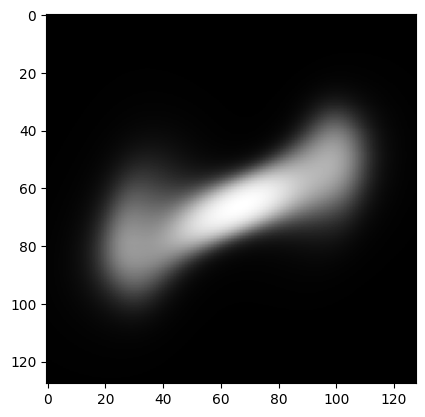

In [8]:
from infer import *

# 모델 로드
model = INRformer().to('cuda')

# 체크포인트 로드
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])  # 모델 상태만 로드

print(f"Loaded model from epoch {checkpoint['epoch']}")
print(f"Train loss: {checkpoint['train_loss']:.4f}")
print(f"Val loss: {checkpoint['val_loss']:.4f}")

# 1. 단일 이미지 생성
image = generate_image(model, label=1,image_size = 128)
plt.imshow(image, cmap='gray')
plt.show()